# Building a vectorized neural network with tensors

To demonstrate the power of `Tensor`, we'll need a dataset to test out our neural network. We'll use our good old friend, the spiral dataset.

In [1]:
import numpy as np
from mlfz.nn import Tensor


def generate_spiral_dataset(n_points, noise=0.5, twist=380):
    random_points = np.sqrt(np.random.rand(n_points)) * twist * 2 * np.pi / 360

    class_1 = np.column_stack((-np.cos(random_points) * random_points + np.random.rand(n_points) * noise,
                               np.sin(random_points) * random_points + np.random.rand(n_points) * noise))
    class_2 = np.column_stack((np.cos(random_points) * random_points + np.random.rand(n_points) * noise,
                               -np.sin(random_points) * random_points + np.random.rand(n_points) * noise))

    xs = np.vstack((class_1, class_2))
    ys = np.hstack((np.zeros(n_points), np.ones(n_points))).reshape(-1, 1)
    
    return Tensor(xs), Tensor(ys)

In [2]:
xs, ys = generate_spiral_dataset(200, noise=2)

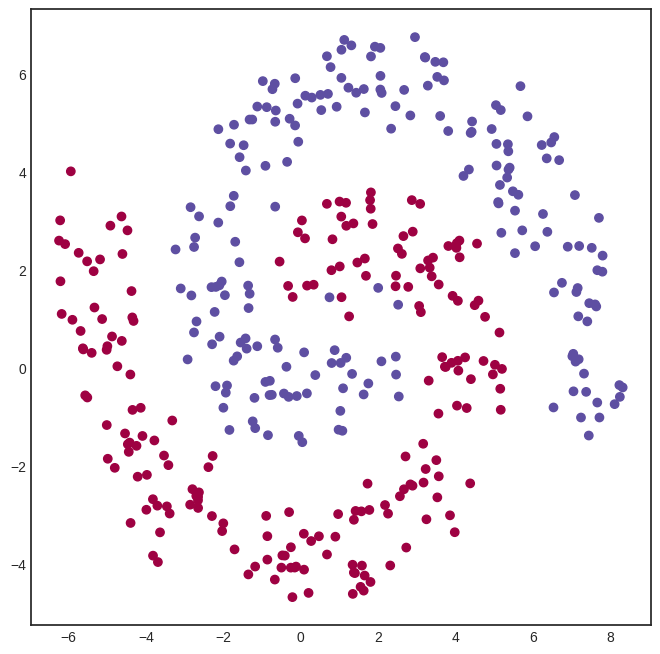

In [3]:
import matplotlib.pyplot as plt


with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 8))
    plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral)
    plt.show()

To define a network, we'll once again use the `Model` class from `mlfz.nn`.

In [4]:
from mlfz.nn import Model
from mlfz.nn.tensor.functional import tanh, sigmoid


class TwoLayerNetwork(Model):
    def __init__(self):
        self.A = Tensor.from_random(2, 8)
        self.B = Tensor.from_random(8, 8)
        self.C = Tensor.from_random(8, 1)

    def forward(self, x):
        return sigmoid(tanh(tanh(x @ self.A) @ self.B) @ self.C)
    
    def parameters(self):
        return {"A": self.A, "B": self.B, "C": self.C}

Look at how simple this implementation is, compared to {ref}`the scalar version <computational-graphs:mlp:a-multi-layer-network>`. Writing expressions like `tanh(x @ A)` makes all the difference.

Training tensor networks is also much faster, as we shall see soon. Let's initialize one and see how it looks.

In [5]:
model = TwoLayerNetwork()

/tmp/ipykernel_13800/4170422174.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz[i, j] = model.forward(Tensor([xx[i, j], yy[i, j]])).value


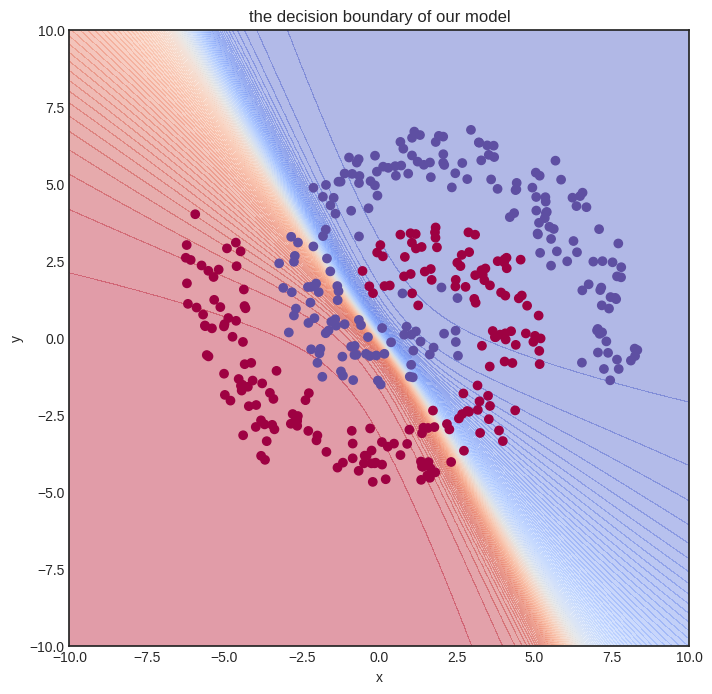

In [6]:
from itertools import product


def visualize_model(model, xs, ys, res=100, xrange=(-10, 10), yrange=(-10, 10)):
    with plt.style.context("seaborn-v0_8-white"):
        plt.figure(figsize=(8, 8))
        
        res = 100
        x = np.linspace(xrange[0], xrange[1], res)
        y = np.linspace(yrange[0], yrange[1], res)
        xx, yy = np.meshgrid(x, y)
        zz = np.zeros_like(xx)
        
        for i, j in product(range(res), range(res)):
            zz[i, j] = model.forward(Tensor([xx[i, j], yy[i, j]])).value


        # plot the decision boundary
        plt.contourf(xx, yy, zz, levels=100, cmap='coolwarm_r', alpha=0.4)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('the decision boundary of our model')
        
        # plot the data
        plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral, zorder=10)
        plt.show()

visualize_model(model, xs, ys)

Here goes the training. We'll let it rip and crunch out a whooping 100000 iterations. For comparison, we merely did 5000 steps for the `Scalar` version, and even that almost made my notebook explode.

In [7]:
from mlfz.nn.tensor.loss import binary_cross_entropy


n_steps = 100000
lr = 0.1

for i in range(1, n_steps + 1):
    preds = model(xs)
    l = binary_cross_entropy(preds, ys)
    l.backward()
    model.gradient_update(lr)

    if i == 1 or i % 10000 == 0:
        print(f"step no. {i}, loss = {l.value}")

step no. 1, loss = 0.9791400926366535
step no. 10000, loss = 0.3308116498063798
step no. 20000, loss = 0.31883484643207033
step no. 30000, loss = 0.3191218809121202
step no. 40000, loss = 0.3182755316375532
step no. 50000, loss = 0.2900075290167234
step no. 60000, loss = 0.302710120482782
step no. 70000, loss = 0.290146452142041
step no. 80000, loss = 0.2780596173544815
step no. 90000, loss = 0.281371373729672
step no. 100000, loss = 0.27949396052592745


In other words, despite having a more complex model and performing way more gradient descent steps, we are still much faster. Let's time it to confirm.

In [8]:
def train_model():
    model = TwoLayerNetwork()
    n_steps = 100000
    lr = 0.1

    for i in range(1, n_steps + 1):
        preds = model(xs)
        l = binary_cross_entropy(preds, ys)
        l.backward()
        model.gradient_update(lr)


%timeit -r 1 -n 1 train_model()

And this is the final result.

/tmp/ipykernel_14581/4170422174.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz[i, j] = model.forward(Tensor([xx[i, j], yy[i, j]])).value


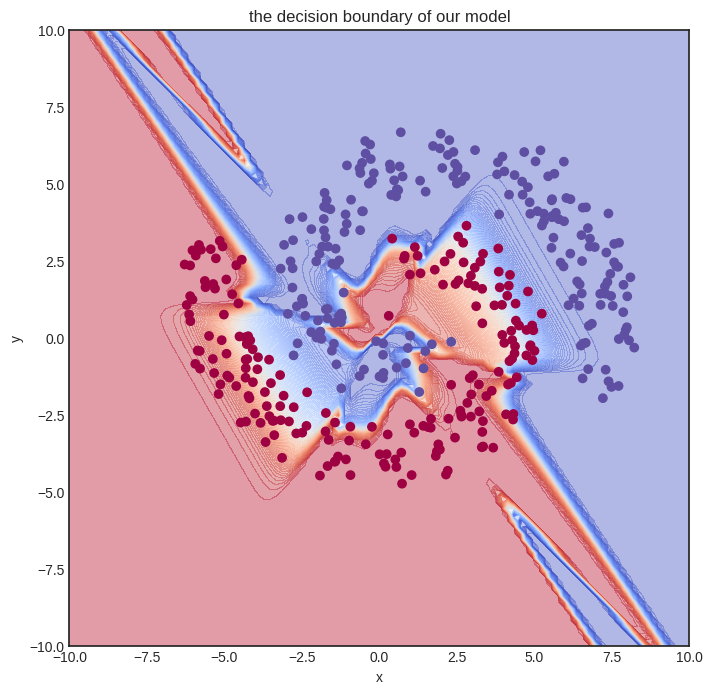

In [ ]:
visualize_model(model, xs, ys)